# Project 5


#### Read MNIST Dataset

In [1]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

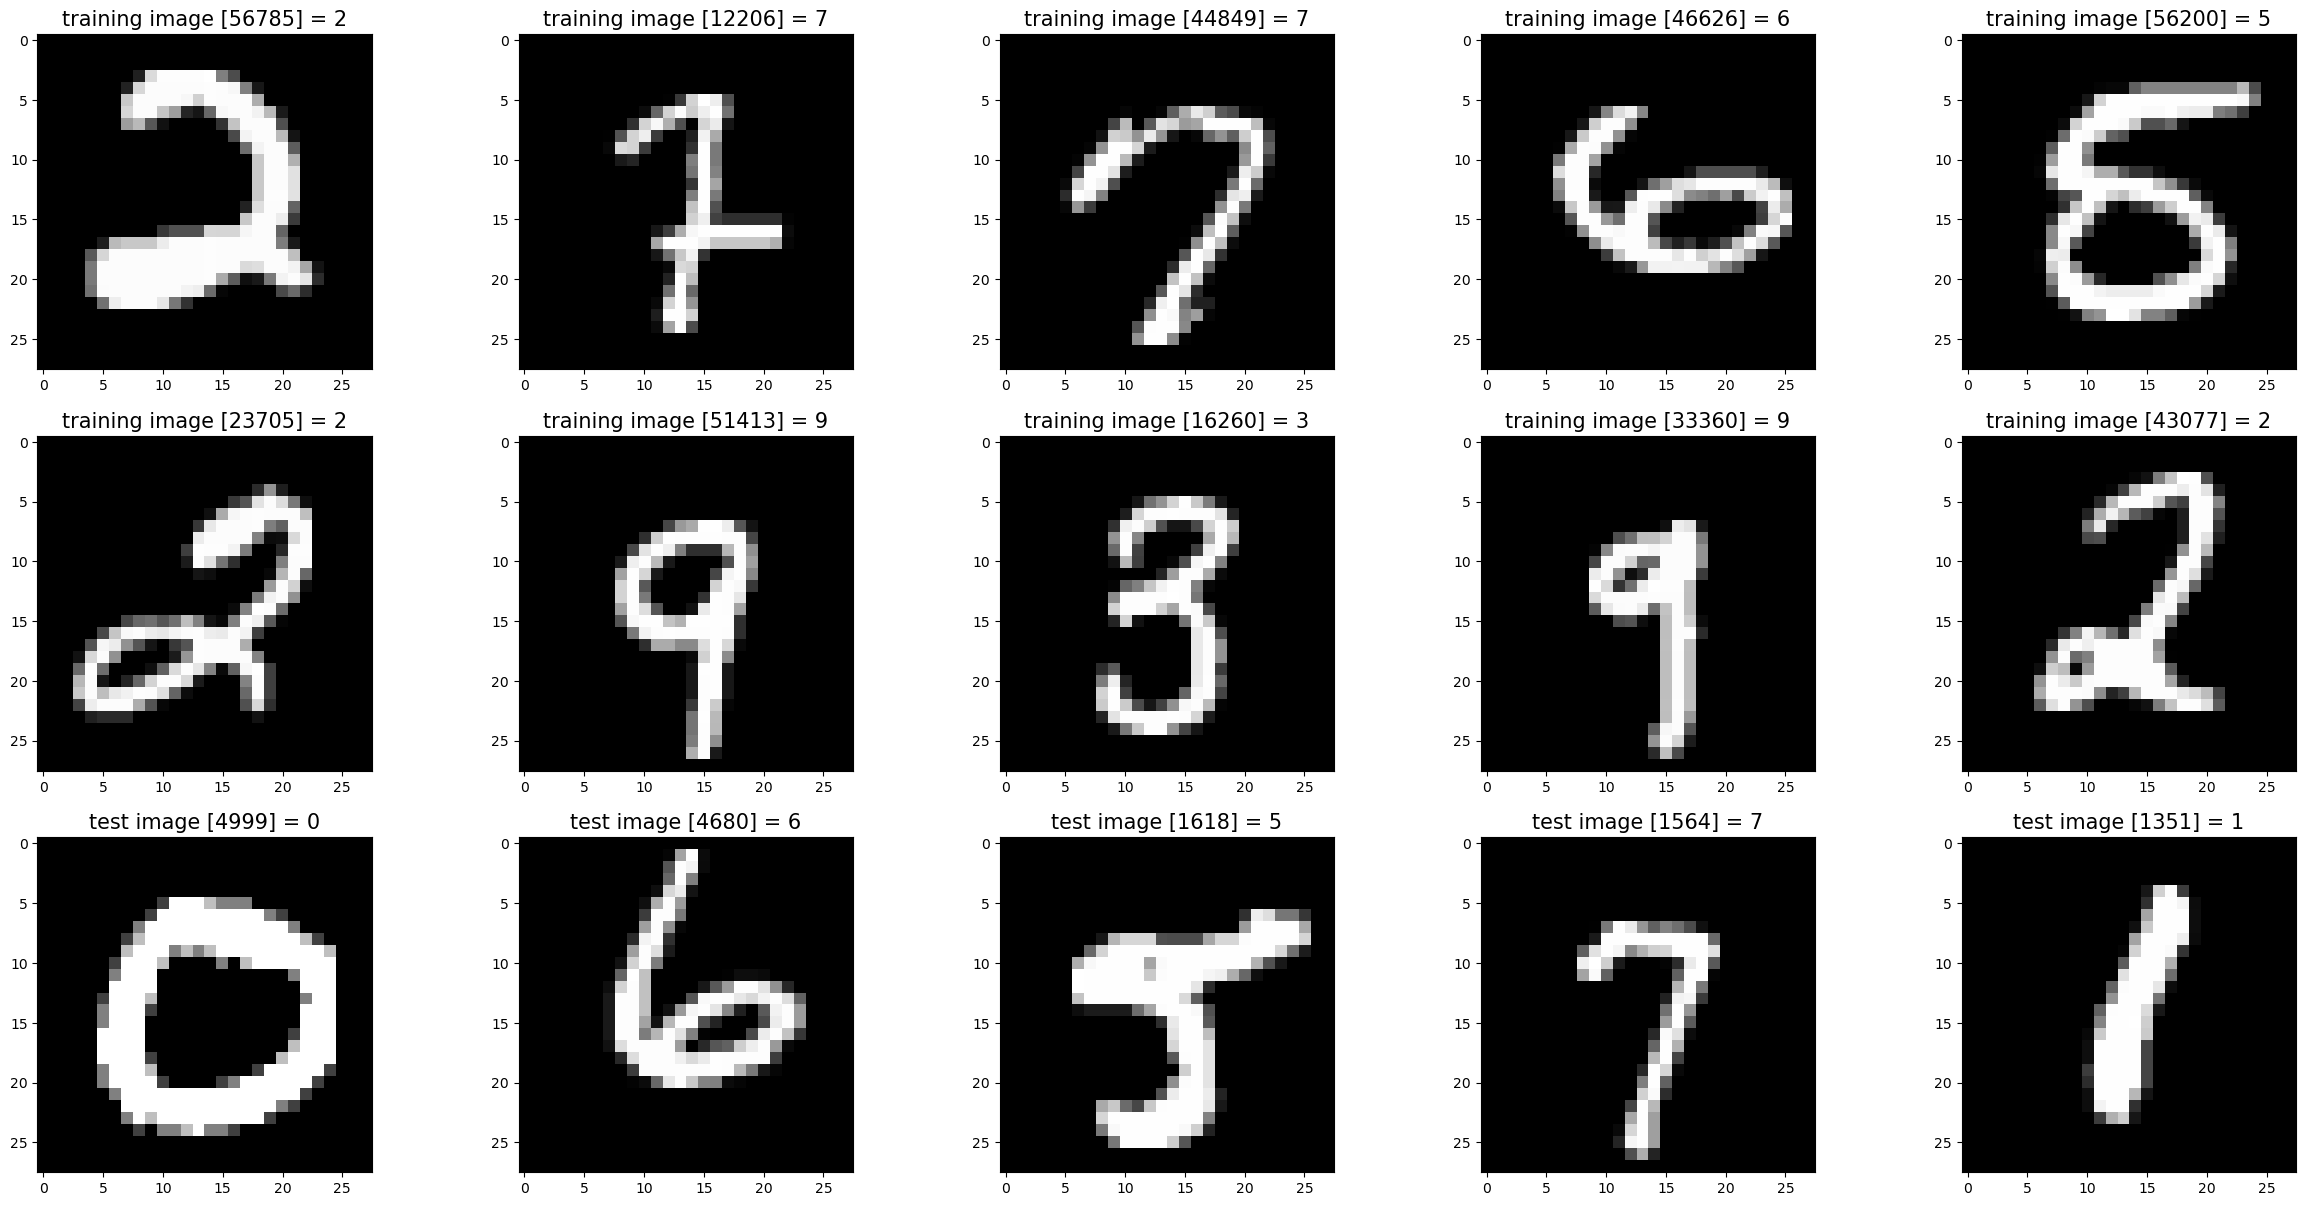

In [2]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = './input/train-images-idx3-ubyte/train-images.idx3-ubyte'
training_labels_filepath = './input/train-labels-idx1-ubyte/train-labels.idx1-ubyte'
test_images_filepath = './input/t10k-images-idx3-ubyte/t10k-images.idx3-ubyte'
test_labels_filepath = './input/t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

#### Setup data 

In [3]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train_vectors = []
y_test_vectors = []

for i, label in enumerate(y_train):
    temp = np.zeros(10)
    if label == 0:
        temp[9] = 1
    else:
        temp[label - 1] = 1
    y_train_vectors.append(temp)
    
for i, label in enumerate(y_test):
    temp = np.zeros(10)
    if label == 0:
        temp[9] = 1
    else:
        temp[label - 1] = 1
    y_test_vectors.append(temp)
    
y_train_vectors = np.array(y_train_vectors)
y_test_vectors = np.array(y_test_vectors)

# reshape x into 1 x 784 array
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

#### Create Neural Network

In [4]:
def initialize_weights(s2, epsilon):
    # initialize W1 and W2
    # Dimensions:
    # W1 = s2 * 785
    # W2 = 10 * (s2 + 1)
    W1 = np.random.uniform(-epsilon, epsilon, (s2, 785))
    W2 = np.random.uniform(-epsilon, epsilon, (10, (s2 + 1)))
    return W1, W2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradient_descent(x_train, y_train, W1, W2, learning_rate, max_iterations = 10000):
    N = 10000
    
    prev_W1 = W1
    prev_W2 = W2
    for iteration in range(max_iterations):
        # Select N random points from x_train to make iterations faster
        indices = np.random.choice(x_train.shape[0], N, replace=False)
        if iteration % 10 == 0:
            print(iteration, "/", max_iterations)
        
        for i in range(N):
            x = x_train[i]
            y = y_train[i]
            
            # Feed Forward
            a1 = np.insert(x, 0, 1)
            z2 = W1 @ a1
            a2 = np.insert(sigmoid(z2), 0, 1)
            z3 = W2 @ a2
            a3 = sigmoid(z3)
            
            # Back Propagation
            d3 = a3 - y
            W_2 = np.delete(W2, 0, 1)
            d2 = np.multiply((W_2.T @ d3), sigmoid(z2) * (1 - sigmoid(z2)))
            
            gW1 = d2.reshape(-1, 1) @ a1.reshape(1, -1)
            gW2 = d3.reshape(-1, 1) @ a2.reshape(1, -1)
            
            # Compute Gradients
            gradW1 = gW1 / N
            gradW2 = gW2 / N
            
            # Update Rule
            prev_W1 = W1
            prev_W2 = W2
            W1 = prev_W1 - learning_rate * gradW1
            W2 = prev_W2 - learning_rate * gradW2
        
    return W1, W2

#### Train Neural Network

In [5]:
W1, W2 = initialize_weights(30, 0.1)

W1, W2 = gradient_descent(x_train, y_train_vectors, W1, W2, 0.01)

0 / 10000
10 / 10000
20 / 10000
30 / 10000
40 / 10000
50 / 10000
60 / 10000
70 / 10000
80 / 10000
90 / 10000
100 / 10000
110 / 10000
120 / 10000
130 / 10000
140 / 10000
150 / 10000
160 / 10000
170 / 10000
180 / 10000
190 / 10000
200 / 10000
210 / 10000
220 / 10000
230 / 10000
240 / 10000
250 / 10000
260 / 10000
270 / 10000
280 / 10000
290 / 10000
300 / 10000
310 / 10000
320 / 10000
330 / 10000
340 / 10000
350 / 10000
360 / 10000
370 / 10000
380 / 10000
390 / 10000
400 / 10000
410 / 10000
420 / 10000
430 / 10000
440 / 10000
450 / 10000
460 / 10000
470 / 10000
480 / 10000
490 / 10000
500 / 10000
510 / 10000
520 / 10000
530 / 10000
540 / 10000
550 / 10000
560 / 10000
570 / 10000
580 / 10000
590 / 10000
600 / 10000
610 / 10000
620 / 10000
630 / 10000
640 / 10000
650 / 10000
660 / 10000
670 / 10000
680 / 10000
690 / 10000
700 / 10000
710 / 10000
720 / 10000
730 / 10000
740 / 10000
750 / 10000
760 / 10000
770 / 10000
780 / 10000
790 / 10000
800 / 10000
810 / 10000
820 / 10000
830 / 10000
840

C:\Users\Luke\AppData\Local\Temp\ipykernel_24476\3918407459.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


1100 / 10000
1110 / 10000
1120 / 10000
1130 / 10000
1140 / 10000
1150 / 10000
1160 / 10000
1170 / 10000
1180 / 10000
1190 / 10000
1200 / 10000
1210 / 10000
1220 / 10000
1230 / 10000
1240 / 10000
1250 / 10000
1260 / 10000
1270 / 10000
1280 / 10000
1290 / 10000
1300 / 10000
1310 / 10000
1320 / 10000
1330 / 10000
1340 / 10000
1350 / 10000
1360 / 10000
1370 / 10000
1380 / 10000
1390 / 10000
1400 / 10000
1410 / 10000
1420 / 10000
1430 / 10000
1440 / 10000
1450 / 10000
1460 / 10000
1470 / 10000
1480 / 10000
1490 / 10000
1500 / 10000
1510 / 10000
1520 / 10000
1530 / 10000
1540 / 10000
1550 / 10000
1560 / 10000
1570 / 10000
1580 / 10000
1590 / 10000
1600 / 10000
1610 / 10000
1620 / 10000
1630 / 10000
1640 / 10000
1650 / 10000
1660 / 10000
1670 / 10000
1680 / 10000
1690 / 10000
1700 / 10000
1710 / 10000
1720 / 10000
1730 / 10000
1740 / 10000
1750 / 10000
1760 / 10000
1770 / 10000
1780 / 10000
1790 / 10000
1800 / 10000
1810 / 10000
1820 / 10000
1830 / 10000
1840 / 10000
1850 / 10000
1860 / 10000

#### Test Neural Network

In [20]:
np.set_printoptions(precision=6, suppress=True)

N = x_test.shape[0]


correct_predictions = 0

for i in range(N):
    x = x_test[i]
    y = y_test[i]
    
    a1 = np.insert(x, 0, 1)
    z2 = W1 @ a1
    a2 = np.insert(sigmoid(z2), 0, 1)
    z3 = W2 @ a2
    a3 = sigmoid(z3)
    
    # Get label with highest activation value
    predicted_label = np.argmax(a3)
    
    # Check if the prediction actual label
    if predicted_label == 9:
        if y == 0:
            correct_predictions += 1
    else:
        if predicted_label + 1 == y:
            correct_predictions += 1
            

accuracy = correct_predictions / N
print(f"Accuracy: {accuracy * 100:.2f}%")
    

C:\Users\Luke\AppData\Local\Temp\ipykernel_24476\3918407459.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 84.39%


#### Train Different Size

In [ ]:
W_1, W_2 = initialize_weights(60, 0.1)

W_1, W_2 = gradient_descent(x_train, y_train_vectors, W_1, W_2, 0.01)

#### Test Different Size

In [22]:
N = x_test.shape[0]

correct_predictions = 0

for i in range(N):
    x = x_test[i]
    y = y_test[i]
    
    a1 = np.insert(x, 0, 1)
    z2 = W_1 @ a1
    a2 = np.insert(sigmoid(z2), 0, 1)
    z3 = W_2 @ a2
    a3 = sigmoid(z3)
    
    # Get label with highest activation value
    predicted_label = np.argmax(a3)
    
    # Check if the prediction actual label
    if predicted_label == 9:
        if y == 0:
            correct_predictions += 1
    else:
        if predicted_label + 1 == y:
            correct_predictions += 1
            

accuracy = correct_predictions / N
print(f"Accuracy: {accuracy * 100:.2f}%")

C:\Users\Luke\AppData\Local\Temp\ipykernel_24476\3918407459.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 87.61%


#### Write Weights into a File

In [23]:
# Write Weights into a file
with open('weights.txt', 'w') as file:
        file.write("W1:\n")
        for row in W1:
            for element in row:
                file.write(f"{element} ")
            file.write("\n")
        
        file.write("W2:\n")
        for row in W2:
            for element in row:
                file.write(f"{element} ")
            file.write("\n")
            
with open('weights2.txt', 'w') as file:
        file.write("W1:\n")
        for row in W_1:
            for element in row:
                file.write(f"{element} ")
            file.write("\n")
        
        file.write("W2:\n")
        for row in W_2:
            for element in row:
                file.write(f"{element} ")
            file.write("\n")